In [1]:
%cd "C:\Users\siddh\Downloads"
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import tensorflow_datasets as tfds

C:\Users\siddh\Downloads


C:\Users\siddh\anaconda3\envs\tf_gpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\siddh\anaconda3\envs\tf_gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dir = r"C:\Users\siddh\Downloads\Wall Crack Dataset\train"
val_dir = r"C:\Users\siddh\Downloads\Wall Crack Dataset\valid"
test_dir = r"C:\Users\siddh\Downloads\Wall Crack Dataset\test"

In [3]:
import pathlib
data_dir_train = pathlib.Path(train_dir).with_suffix('')
data_dir_val = pathlib.Path(val_dir).with_suffix('')
data_dir_test = pathlib.Path(test_dir).with_suffix('')

In [5]:
import PIL
import PIL.Image
crack = list(data_dir_train.glob('positive/*'))

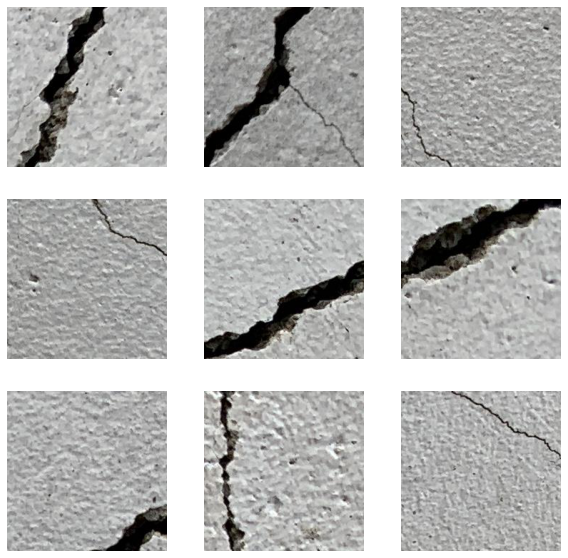

In [6]:
plt.figure(figsize = (10,10))
for i in range(9):
    img = plt.imread(crack[i])
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.axis(False)

In [8]:
IMG_SIZE = (256,256)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode = "binary",
                                                                image_size = IMG_SIZE)


val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                               label_mode = "binary",
                                                               image_size = IMG_SIZE)    #Don't shuffle the dataset for now

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode = "binary",
                                                               image_size = IMG_SIZE)

Found 600 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


In [10]:
class_names = train_ds.class_names
print(class_names)

['Negative', 'Positive']


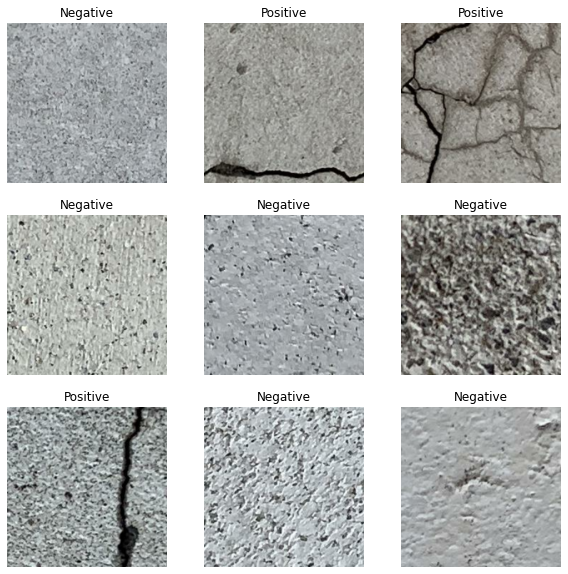

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [42]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


In [25]:
base_model = tf.keras.applications.EfficientNetV2B0(include_top = False,input_shape=(256,256,3))
base_model.trainable=True

inputs = tf.keras.layers.Input(shape = (256,256,3), name = "Input_layer")
print(inputs.shape)
x = base_model(inputs,training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name = "Global_average_pooling_layer")(x)
x = tf.keras.layers.Dense(50, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(25, activation = "relu")(x)
outputs = tf.keras.layers.Dense(1, activation = "sigmoid", name = "Output_layer")(x)
model = tf.keras.Model(inputs,outputs)

model.summary()

(None, 256, 256, 3)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, 8, 8, 1280)       5919312   
 al)                                                             
                                                                 
 Global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dense_2 (Dense)             (None, 50)                64050     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 25)

In [26]:
from keras import backend as K
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

In [38]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(lr=0.001),
  loss = "binary_crossentropy",
  metrics=["accuracy",f1,precision,recall])

In [39]:
history = model.fit(train_data, 
                       epochs = 10, 
                       steps_per_epoch = len(train_data)//2, 
                       validation_data = val_data, 
                       batch_size = 32, 
                       validation_steps = len(val_data))

Epoch 1/10
9/9 [==============================] - 11s 389ms/step - loss: 0.0485 - accuracy: 0.9931 - f1: 0.9921 - precision: 0.9926 - recall: 0.9921 - val_loss: 0.9257 - val_accuracy: 0.9700 - val_f1: 0.9726 - val_precision: 1.0000 - val_recall: 0.9490
Epoch 2/10
9/9 [==============================] - 2s 245ms/step - loss: 0.6098 - accuracy: 0.9236 - f1: 0.9256 - precision: 0.9315 - recall: 0.9314 - val_loss: 0.3317 - val_accuracy: 0.8900 - val_f1: 0.8851 - val_precision: 0.7998 - val_recall: 1.0000
Epoch 3/10
1/9 [==>...........................] - ETA: 1s - loss: 0.1092 - accuracy: 0.9167 - f1: 0.9412 - precision: 0.9412 - recall: 0.9412WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 90 batches). You may need to use the repeat() function when building your dataset.


9/9 [==============================] - 2s 177ms/step - loss: 0.1092 - accuracy: 0.9167 - f1: 0.9412 - precision: 0.9412 - recall: 0.9412 - val_loss: 0.1854 - val_accuracy: 0.9150 - val_f1: 0.9171 - val_precision: 0.8477 - val_recall: 1.0000


In [40]:
model.evaluate(test_data)

7/7 [==============================] - 0s 58ms/step - loss: 0.0467 - accuracy: 1.0000 - f1: 1.0000 - precision: 1.0000 - recall: 1.0000


[0.046697236597537994, 1.0, 1.0, 1.0, 1.0]

In [41]:
model.save(filepath=r"C:\Users\siddh\Downloads\new_model")

INFO:tensorflow:Assets written to: C:\Users\siddh\Downloads\new_model\assets


INFO:tensorflow:Assets written to: C:\Users\siddh\Downloads\new_model\assets
